In [ ]:
import os, math
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.datasets import cifar10, mnist
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization 
from tensorflow.keras.layers import Conv2D, Flatten, Activation
from tensorflow.keras.layers import Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mse, SparseCategoricalCrossentropy


In [ ]:
tf.random.set_seed(42)


In [ ]:
(x_train, y_train),(x_test, _) = mnist.load_data()


In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train / 255

In [ ]:
x_train.max()

1.0

In [ ]:
image_size = x_train[0].shape[1]
image_size

28

In [ ]:
class ConvTransBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides):
        super().__init__()
        self.bn = BatchNormalization()  # check training flag
        self.act = Activation(activation='relu')
        self.conv2D_trans = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=strides,
                                padding='same')
        
    def call(self, inputs, training=False):
        x = self.bn(inputs)
        x = self.act(x)
        return self.conv2D_trans(x)


In [ ]:
class Generator(tf.keras.models.Model):
    def __init__(self, filters, kernel_size, resize_img):
        super().__init__()
        self.dense1 = Dense(resize_img * resize_img * filters[0])
        self.reshape = Reshape([resize_img, resize_img, filters[0]])
        self.conv2dtrans = []
        for i, _filter in enumerate(filters):
            if i <= 1:
                strides = 2
            else:
                strides = 1
            self.conv2dtrans.append(ConvTransBlock(_filter, kernel_size, strides))
        
        self.act = Activation("sigmoid")

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.reshape(x)
        for conv in self.conv2dtrans:
            x = conv(x)
        return self.act(x)
    
    def model(self):
        x = Input(shape=[1, 6272])
        return Model(inputs=x, outputs=self.call(x))




In [ ]:
def leaky_conv(filters, kernel_size, strides):
    return Sequential([LeakyReLU(alpha=0.2),
                       Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding='same')])


In [ ]:
class Discriminator(tf.keras.models.Model):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.leaky_convs = []
        for i, _filter in enumerate(filters):
            if i < len(filters) - 1:
                strides = 2
            else:
                strides = 1
            self.leaky_convs.append(leaky_conv(_filter, kernel_size, strides))
        self.flat = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = inputs
        for conv in self.leaky_convs:
            x = conv(x)
        x = self.flat(x)
        return self.dense(x)

In [ ]:
# latent_size = 2??
# simple disc
# delete activation as input in disc


latent_size = 2
batch_size = 512
train_steps = 40000
disc_lr = 2e-4
disc_decay = 6e-8
gen_lr = disc_lr/4
gen_decay = disc_decay/4

disc_lr, disc_decay, gen_lr, gen_decay

(0.0002, 6e-08, 5e-05, 1.5e-08)

In [ ]:
disc_kernel_size = 4
disc_layers_filters = [32, 64, 128]

In [ ]:
gen_resize_img = image_size // 4
gen_kernel_size = 4
gen_layers_filter = [128, 64, 32, 1]

In [ ]:
gen = Generator(gen_layers_filter, gen_kernel_size, gen_resize_img)

In [ ]:
disc = Discriminator(disc_layers_filters, disc_kernel_size)
disc.compile(loss='binary_crossentropy',
             optimizer=RMSprop(learning_rate=disc_lr, decay=disc_decay),
             metrics=['accuracy'])


In [ ]:
def build_gan():
    # disc.trainable = False
    gan = Sequential(name='gan_model')
    gan.add(Input([latent_size,]))
    gan.add(gen)
    gan.add(disc)
    gan.summary()
    gan.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=gen_lr, decay=gen_decay),
                metrics=['accuracy'])            
    return gan   


gan = build_gan()


Model: "gan_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Generator)        (None, 28, 28, 1)         446945    
_________________________________________________________________
discriminator (Discriminator (None, 1)                 170849    
Total params: 617,794
Trainable params: 617,090
Non-trainable params: 704
_________________________________________________________________


In [ ]:
for layer in gan.layers:
    print(layer.trainable)

True
True


In [ ]:
def plot_images(generator,
                noise_input,
                noise_label=None,
                noise_codes=None,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    # Arguments
        generator (Model): The Generator Model for 
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    # os.makedirs(model_name, exist_ok=True)
    # filename = os.path.join(model_name, "%05d.png" % step)
    rows = int(math.sqrt(noise_input.shape[0]))
    if noise_label is not None:
        noise_input = [noise_input, noise_label]
        if noise_codes is not None:
            noise_input += noise_codes

    images = generator.predict(noise_input)
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    # plt.savefig(filename)
    if show:
        
        plt.show()
    else:
        plt.close('all')

In [ ]:
# Train the Discriminator and Adversarial Networks
def train(models, x_train):
    generator, discriminator, gan = models 
    # batch_size, latent_size, train_step, model_name = params
    save_interval = 500
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size]) 
    train_size = x_train.shape[0]

    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_images = generator.predict(noise)        
        x = np.concatenate((real_images, fake_images)) # same size
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        # experimental
        # y[: batch_size] = 1
        discriminator.trainable = True
        loss, acc = discriminator.train_on_batch(x, y)
        # log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        log = f'{i}: [discriminator loss: {loss}, acc: {acc}]'
        discriminator.trainable = False

        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])        
        loss, acc = gan.train_on_batch(noise, y)
        log = "%s [gan loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=True,
                        step=(i + 1),
                        model_name='gan_model')
    

In [ ]:
print(x_train.shape, x_train.min(), x_train.max())
        

(60000, 28, 28, 1) 0.0 1.0


0: [discriminator loss: 0.6887925863265991, acc: 0.7060546875] [gan loss: 0.814798, acc: 0.000000]
1: [discriminator loss: 0.6429523229598999, acc: 0.966796875] [gan loss: 0.814822, acc: 0.000000]
2: [discriminator loss: 0.607060432434082, acc: 0.9951171875] [gan loss: 0.822665, acc: 0.000000]
3: [discriminator loss: 0.5676516890525818, acc: 1.0] [gan loss: 0.827955, acc: 0.000000]
4: [discriminator loss: 0.5279223918914795, acc: 0.9970703125] [gan loss: 0.820941, acc: 0.000000]
5: [discriminator loss: 0.485856294631958, acc: 1.0] [gan loss: 0.781545, acc: 0.000000]
6: [discriminator loss: 0.4402754008769989, acc: 1.0] [gan loss: 0.733953, acc: 0.185547]
7: [discriminator loss: 0.39427459239959717, acc: 1.0] [gan loss: 0.644206, acc: 0.828125]
8: [discriminator loss: 0.3476865291595459, acc: 1.0] [gan loss: 0.565402, acc: 0.933594]
9: [discriminator loss: 0.29942572116851807, acc: 1.0] [gan loss: 0.419309, acc: 1.000000]
10: [discriminator loss: 0.2564335763454437, acc: 1.0] [gan loss:

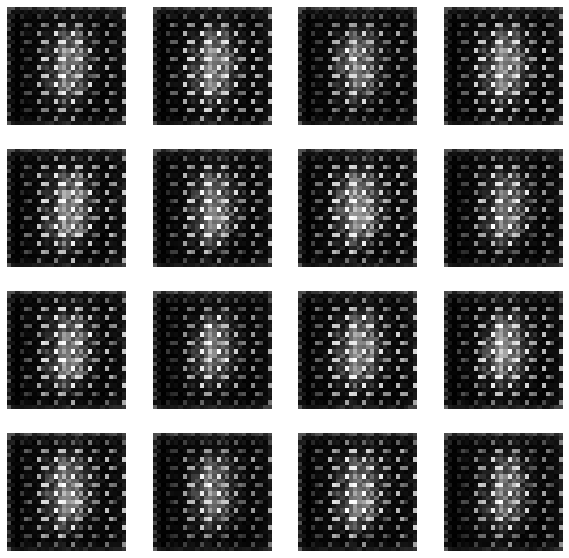

500: [discriminator loss: 0.010309604927897453, acc: 1.0] [gan loss: 1.276872, acc: 0.126953]
501: [discriminator loss: 0.12730202078819275, acc: 0.9921875] [gan loss: 6.586894, acc: 0.000000]
502: [discriminator loss: 0.17694741487503052, acc: 0.9609375] [gan loss: 0.000706, acc: 1.000000]
503: [discriminator loss: 0.2570650577545166, acc: 0.990234375] [gan loss: 3.904898, acc: 0.000000]
504: [discriminator loss: 0.23799782991409302, acc: 0.9423828125] [gan loss: 0.000791, acc: 1.000000]
505: [discriminator loss: 0.14758005738258362, acc: 0.9912109375] [gan loss: 0.179157, acc: 0.994141]
506: [discriminator loss: 0.11596041917800903, acc: 0.9677734375] [gan loss: 0.007715, acc: 1.000000]
507: [discriminator loss: 0.06953224539756775, acc: 0.986328125] [gan loss: 0.009203, acc: 1.000000]
508: [discriminator loss: 0.06373774260282516, acc: 0.9892578125] [gan loss: 0.011085, acc: 1.000000]
509: [discriminator loss: 0.034146323800086975, acc: 0.9921875] [gan loss: 0.016960, acc: 1.000000]

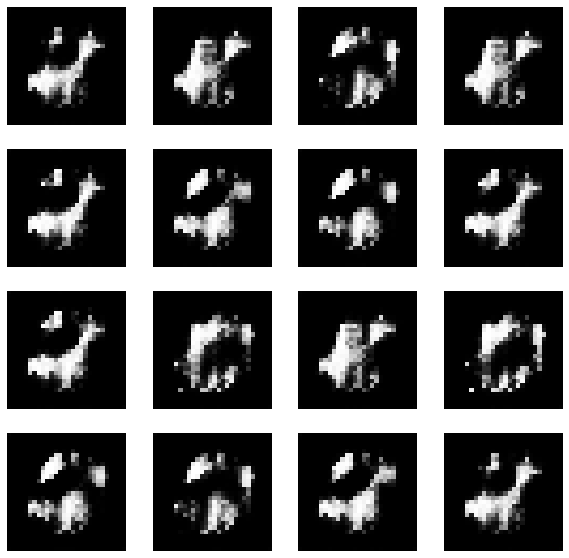

1000: [discriminator loss: 0.7567264437675476, acc: 0.5810546875] [gan loss: 0.344819, acc: 0.931641]
1001: [discriminator loss: 0.8407047986984253, acc: 0.505859375] [gan loss: 1.730919, acc: 0.000000]
1002: [discriminator loss: 0.7353090643882751, acc: 0.5966796875] [gan loss: 0.330944, acc: 0.945312]
1003: [discriminator loss: 0.824394941329956, acc: 0.5087890625] [gan loss: 1.700323, acc: 0.000000]
1004: [discriminator loss: 0.7375137805938721, acc: 0.587890625] [gan loss: 0.314942, acc: 0.957031]
1005: [discriminator loss: 0.8209791779518127, acc: 0.5185546875] [gan loss: 1.625362, acc: 0.000000]
1006: [discriminator loss: 0.7188063859939575, acc: 0.59765625] [gan loss: 0.325789, acc: 0.958984]
1007: [discriminator loss: 0.8252506256103516, acc: 0.515625] [gan loss: 1.606477, acc: 0.000000]
1008: [discriminator loss: 0.7091192007064819, acc: 0.6064453125] [gan loss: 0.346771, acc: 0.935547]
1009: [discriminator loss: 0.7895944118499756, acc: 0.5185546875] [gan loss: 1.447952, acc:

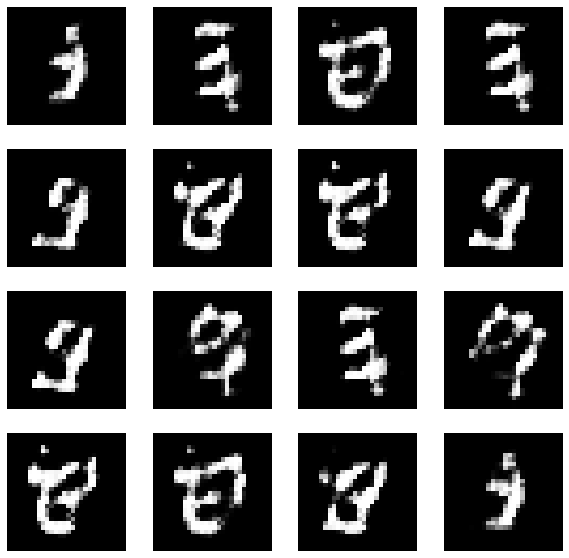

1500: [discriminator loss: 0.6821397542953491, acc: 0.60546875] [gan loss: 0.526917, acc: 1.000000]
1501: [discriminator loss: 0.7318180799484253, acc: 0.4814453125] [gan loss: 1.069261, acc: 0.000000]
1502: [discriminator loss: 0.6786901950836182, acc: 0.5966796875] [gan loss: 0.537652, acc: 1.000000]
1503: [discriminator loss: 0.7150289416313171, acc: 0.4912109375] [gan loss: 1.072121, acc: 0.000000]
1504: [discriminator loss: 0.6677330732345581, acc: 0.6279296875] [gan loss: 0.556236, acc: 1.000000]
1505: [discriminator loss: 0.7139490842819214, acc: 0.4736328125] [gan loss: 1.048339, acc: 0.000000]
1506: [discriminator loss: 0.6734851002693176, acc: 0.6318359375] [gan loss: 0.580075, acc: 0.976562]
1507: [discriminator loss: 0.6978667974472046, acc: 0.4775390625] [gan loss: 1.005544, acc: 0.000000]
1508: [discriminator loss: 0.6595736145973206, acc: 0.6767578125] [gan loss: 0.580340, acc: 0.929688]
1509: [discriminator loss: 0.7021800875663757, acc: 0.4814453125] [gan loss: 1.02110

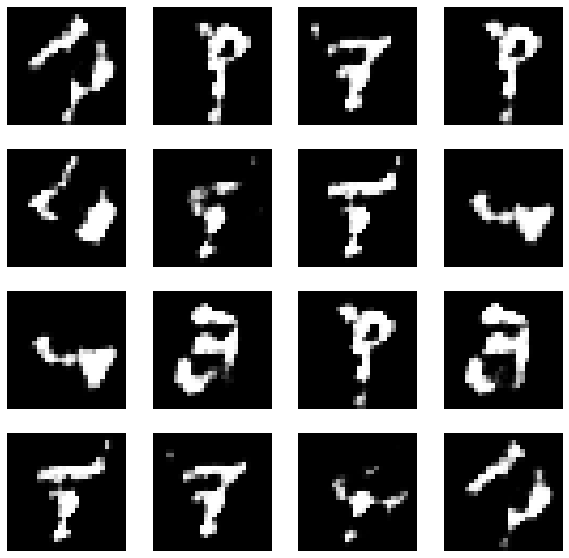

2000: [discriminator loss: 0.6679655313491821, acc: 0.6572265625] [gan loss: 0.679347, acc: 0.599609]
2001: [discriminator loss: 0.6789267659187317, acc: 0.5107421875] [gan loss: 0.867967, acc: 0.000000]
2002: [discriminator loss: 0.6603630781173706, acc: 0.6884765625] [gan loss: 0.678197, acc: 0.566406]
2003: [discriminator loss: 0.6796872019767761, acc: 0.5166015625] [gan loss: 0.917602, acc: 0.000000]
2004: [discriminator loss: 0.6603736877441406, acc: 0.6591796875] [gan loss: 0.635114, acc: 0.794922]
2005: [discriminator loss: 0.6923158764839172, acc: 0.5048828125] [gan loss: 0.979412, acc: 0.000000]
2006: [discriminator loss: 0.6690236330032349, acc: 0.634765625] [gan loss: 0.608282, acc: 0.912109]
2007: [discriminator loss: 0.6941288709640503, acc: 0.5] [gan loss: 0.974484, acc: 0.000000]
2008: [discriminator loss: 0.6585119962692261, acc: 0.6337890625] [gan loss: 0.605438, acc: 0.906250]
2009: [discriminator loss: 0.6940131187438965, acc: 0.498046875] [gan loss: 0.956356, acc: 0

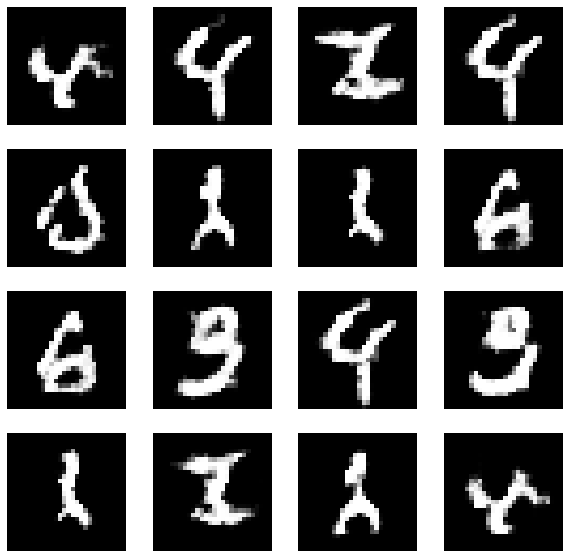

2500: [discriminator loss: 0.6922791600227356, acc: 0.4775390625] [gan loss: 0.872122, acc: 0.000000]
2501: [discriminator loss: 0.6957748532295227, acc: 0.580078125] [gan loss: 0.638099, acc: 0.771484]
2502: [discriminator loss: 0.7002808451652527, acc: 0.48046875] [gan loss: 0.902789, acc: 0.000000]
2503: [discriminator loss: 0.6944421529769897, acc: 0.544921875] [gan loss: 0.611838, acc: 0.880859]
2504: [discriminator loss: 0.6971474885940552, acc: 0.4970703125] [gan loss: 0.920303, acc: 0.000000]
2505: [discriminator loss: 0.6845366358757019, acc: 0.583984375] [gan loss: 0.611617, acc: 0.855469]
2506: [discriminator loss: 0.7070612907409668, acc: 0.4892578125] [gan loss: 0.908902, acc: 0.000000]
2507: [discriminator loss: 0.6881425380706787, acc: 0.580078125] [gan loss: 0.615045, acc: 0.833984]
2508: [discriminator loss: 0.7008164525032043, acc: 0.4970703125] [gan loss: 0.895021, acc: 0.000000]
2509: [discriminator loss: 0.6940073370933533, acc: 0.51953125] [gan loss: 0.649085, acc

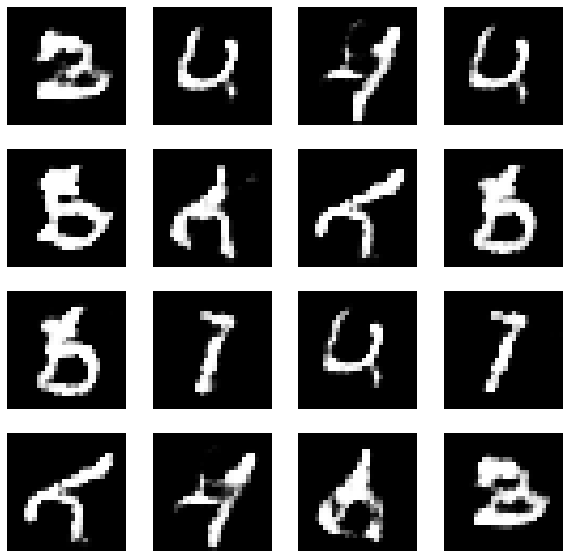

3000: [discriminator loss: 0.6685032844543457, acc: 0.607421875] [gan loss: 0.668647, acc: 0.642578]
3001: [discriminator loss: 0.6728441715240479, acc: 0.513671875] [gan loss: 0.928191, acc: 0.000000]
3002: [discriminator loss: 0.6703016757965088, acc: 0.626953125] [gan loss: 0.665975, acc: 0.642578]
3003: [discriminator loss: 0.667513370513916, acc: 0.53125] [gan loss: 0.954200, acc: 0.000000]
3004: [discriminator loss: 0.6661546230316162, acc: 0.626953125] [gan loss: 0.631201, acc: 0.742188]
3005: [discriminator loss: 0.682590126991272, acc: 0.50390625] [gan loss: 0.980754, acc: 0.000000]
3006: [discriminator loss: 0.6728971600532532, acc: 0.6142578125] [gan loss: 0.636565, acc: 0.730469]
3007: [discriminator loss: 0.6789567470550537, acc: 0.5107421875] [gan loss: 0.976744, acc: 0.000000]
3008: [discriminator loss: 0.672558605670929, acc: 0.62890625] [gan loss: 0.639393, acc: 0.744141]
3009: [discriminator loss: 0.6756165623664856, acc: 0.529296875] [gan loss: 0.955318, acc: 0.00000

KeyboardInterrupt: ignored

In [ ]:
train(models=[gen, disc, gan], x_train=x_train)

In [ ]:
for layer in gen.layers:
    try:
        print(layer.name, layer.input)
        # print()
        # weights = layer.get_weights()[0]
        # print(weights.mean(), weights.std(), weights.shape)
    except:
        pass

In [ ]:
X = tf.random.uniform((1,6272))
for layer in gen.layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [ ]:
gen.model().summary()

In [ ]:
imgs_in_row = 20
l1 = np.linspace(-1, 1, imgs_in_row)
l2 = np.linspace(-1, 1, imgs_in_row)
noise = np.array([l1, l2]).T


In [ ]:
i = 0
plt.figure(figsize=(15, 15))
for n in range(imgs_in_row):
    for m in range(imgs_in_row):
        i += 1
        plt.subplot(imgs_in_row, imgs_in_row, i)
        image = gen.predict(np.array([l1[m], l2[n]]).reshape(-1, 2)).reshape(28, 28)
        # image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        if i % 2 == 0:
            plt.title(f"{round(l1[m], 2)}, {round(l2[n], 2)}")
        plt.axis('off')



In [ ]:
l1, l2


In [ ]:
plot_images(gen, noise)

In [ ]:
np.array([l1[m], l2[n]]).reshape(-1, 2).shape